In [434]:
import os
import io
import boto3
import numpy as np
import glob as glob
import torch
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split
import multiprocessing

filepath = './tess_data'
S3_BUCKET = 'preprocess-tess-data-bucket'
S3_PREFIX = 'tess_data/'

In [433]:
s3_client = boto3.client('s3')
paginator = s3_client.get_paginator('list_objects_v2')
response_iterator = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)

file_names = []
for response in response_iterator:
    for object_data in response['Contents']:
        key = object_data['Key']
        if key.endswith('global.pkl'):
            file_names.append(key)

file_names

['tess_data/101955023_01_global.pkl',
 'tess_data/103633434_01_global.pkl',
 'tess_data/103751498_01_global.pkl',
 'tess_data/121660904_01_global.pkl',
 'tess_data/122441491_01_global.pkl',
 'tess_data/123233041_01_global.pkl',
 'tess_data/13349647_01_global.pkl',
 'tess_data/137402055_01_global.pkl',
 'tess_data/14661418_01_global.pkl',
 'tess_data/14770122_01_global.pkl',
 'tess_data/154716798_01_global.pkl',
 'tess_data/158588995_01_global.pkl',
 'tess_data/180695581_01_global.pkl',
 'tess_data/183537452_01_global.pkl',
 'tess_data/184240683_01_global.pkl',
 'tess_data/191284318_01_global.pkl',
 'tess_data/198108326_01_global.pkl',
 'tess_data/204317710_01_global.pkl',
 'tess_data/207077681_01_global.pkl',
 'tess_data/211438925_01_global.pkl',
 'tess_data/231670397_01_global.pkl',
 'tess_data/240681314_01_global.pkl',
 'tess_data/248075138_01_global.pkl',
 'tess_data/251848941_01_global.pkl',
 'tess_data/257605131_01_global.pkl',
 'tess_data/257605131_02_global.pkl',
 'tess_data/257

In [2]:
# try the default kepler data loader in exonet.py
# reference: https://gitlab.com/frontierdevelopmentlab/exoplanets/exonet-pytorch/-/blob/master/exonet.py
class KeplerDataLoader(Dataset):
    
    '''
    
    PURPOSE: DATA LOADER FOR KERPLER LIGHT CURVES
    INPUT: PATH TO DIRECTOR WITH LIGHT CURVES + INFO FILES
    OUTPUT: LOCAL + GLOBAL VIEWS, LABELS
    
    '''

    def __init__(self, filepath):

        ### list of global, local, and info files (assumes certain names of files)
        self.flist_global = np.sort(glob.glob(os.path.join(filepath, '*global_flux.npy')))
        self.flist_local = np.sort(glob.glob(os.path.join(filepath, '*local_flux.npy')))
        self.flist_info = np.sort(glob.glob(os.path.join(filepath, '*info.npy')))
        
        print(len(self.flist_global))
        
        ### list of whitened centroid files
        self.flist_global_cen = np.sort(glob.glob(os.path.join(filepath, '*global_cen.npy')))
        self.flist_local_cen = np.sort(glob.glob(os.path.join(filepath, '*local_cen.npy')))
        
        ### ids = {TIC}_{TCE}
        self.ids = np.sort([(x.split('/')[-1]).split('_')[1] + '_' + (x.split('/')[-1]).split('_')[2] for x in self.flist_global])

    def __len__(self):

        return self.ids.shape[0]

    def __getitem__(self, idx):


        ### grab local and global views
        data_global = np.load(self.flist_global[idx]).astype(np.float32)
        data_local = np.load(self.flist_local[idx]).astype(np.float32)

        ### grab centroid views
        data_global_cen = np.load(self.flist_global_cen[idx]).astype(np.float32)
        data_local_cen = np.load(self.flist_local_cen[idx]).astype(np.float32)
        
        ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
        data_info = np.load(self.flist_info[idx])

        return (data_local, data_global, data_local_cen, data_global_cen, data_info[3:]), data_info[2]


In [458]:
# try the default kepler data loader in exonet.py
# reference: https://gitlab.com/frontierdevelopmentlab/exoplanets/exonet-pytorch/-/blob/master/exonet.py
class TessDataLoader(Dataset):
    
    '''
    
    PURPOSE: DATA LOADER FOR KERPLER LIGHT CURVES
    INPUT: PATH TO DIRECTOR WITH LIGHT CURVES + INFO FILES
    OUTPUT: LOCAL + GLOBAL VIEWS, LABELS
    
    '''

    def __init__(self):

        self.s3_client = boto3.client('s3')
        ### list of global, local, and info files (assumes certain names of files)
        self.flist_global = self.__load_file_list__('global.pkl')
        self.flist_local = self.__load_file_list__('local.pkl')
        self.flist_info = self.__load_file_list__('info.pkl')
        
        print(len(self.flist_global))
        
        ### list of whitened centroid files
        self.flist_global_cen = self.__load_file_list__('global_cen.pkl')
        self.flist_local_cen = self.__load_file_list__('local_cen.pkl')
        
        ### ids = {TIC}_{TCE}
        self.ids = np.sort([(x.split('/')[-1]).split('_')[1] + '_' + (x.split('/')[-1]).split('_')[2] for x in self.flist_global])

    def __len__(self):

        return self.ids.shape[0]

    def __getitem__(self, idx):


        ### grab local and global views
        data_global = self.__load_contents_from_s3__(self.flist_global[idx])
        data_local = self.__load_contents_from_s3__(self.flist_local[idx])

        ### grab centroid views
        data_global_cen = self.__load_contents_from_s3__(self.flist_global_cen[idx])
        data_local_cen = self.__load_contents_from_s3__(self.flist_local_cen[idx])
        
        ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
        data_info = self.__load_contents_from_s3__(self.flist_info[idx])

        return (data_local, data_global, data_local_cen, data_global_cen, data_info[3:]), data_info[2]

    def __load_file_list__(self, filename_endswith):
        paginator = self.s3_client.get_paginator('list_objects_v2')
        response_iterator = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)

        file_names = []
        for response in response_iterator:
            for object_data in response['Contents']:
                key = object_data['Key']
                if key.endswith(filename_endswith):
                    file_names.append(key)

        return np.sort(file_names)

    def __load_contents_from_s3__(self, filename):
        bytes_data = io.BytesIO()
        self.s3_client.download_fileobj(S3_BUCKET, filename, bytes_data)
        bytes_data.seek(0)
        contents = np.load(bytes_data, allow_pickle=True)

        return contents
        
        

In [459]:
tess_data_s3 = TessDataLoader()

769


In [450]:
tess_data = KeplerDataLoader(filepath = filepath)

3060


In [463]:
# look through some of the data
count = 0

for data in tess_data_s3:
    print("len(data):", len(data))
    print("len(data[0]):", len(data[0]))
    print("shape data[0][0]: (data_local):", data[0][0].shape)
    print("shape data[0][1]: (data_global):", data[0][1].shape)
    print("shape data[0][2]: (data_local_cen):", data[0][2].shape)
    print("shape data[0][3]: (data_global_cen):", data[0][3].shape)
    print("shape data[0][4]: (data_info[6:]):", data[0][4].shape)
    print("data[1]:", data[1])
    print()

    count += 1
    if count == 2:
        break

len(data): 2
len(data[0]): 5
shape data[0][0]: (data_local): (61,)
shape data[0][1]: (data_global): (201,)
shape data[0][2]: (data_local_cen): (61,)
shape data[0][3]: (data_global_cen): (201,)
shape data[0][4]: (data_info[6:]): (17,)
data[1]: 1.0

len(data): 2
len(data[0]): 5
shape data[0][0]: (data_local): (61,)
shape data[0][1]: (data_global): (201,)
shape data[0][2]: (data_local_cen): (61,)
shape data[0][3]: (data_global_cen): (201,)
shape data[0][4]: (data_info[6:]): (17,)
data[1]: 1.0



In [5]:
# unload all of the data from pytorch dataset to numpy and save
x = []
y = []

curr = 0
total = len(tess_data)
print("Loading validation data:")
for x_data, y_data in tess_data:
    print(curr, "/", total)
    if not isinstance(y_data, np.float64):
        print(f'ERROR: {y_data}')
    curr += 1
    
    x.append(x_data)
    y.append(y_data)

Loading validation data:
0 / 3060
1 / 3060
2 / 3060
3 / 3060
4 / 3060
5 / 3060
6 / 3060
7 / 3060
8 / 3060
9 / 3060
10 / 3060
11 / 3060
12 / 3060
13 / 3060
14 / 3060
15 / 3060
16 / 3060
17 / 3060
18 / 3060
19 / 3060
20 / 3060
21 / 3060
22 / 3060
23 / 3060
24 / 3060
25 / 3060
26 / 3060
27 / 3060
28 / 3060
29 / 3060
30 / 3060
31 / 3060
32 / 3060
33 / 3060
34 / 3060
35 / 3060
36 / 3060
37 / 3060
38 / 3060
39 / 3060
40 / 3060
41 / 3060
42 / 3060
43 / 3060
44 / 3060
45 / 3060
46 / 3060
47 / 3060
48 / 3060
49 / 3060
50 / 3060
51 / 3060
52 / 3060
53 / 3060
54 / 3060
55 / 3060
56 / 3060
57 / 3060
58 / 3060
59 / 3060
60 / 3060
61 / 3060
62 / 3060
63 / 3060
64 / 3060
65 / 3060
66 / 3060
67 / 3060
68 / 3060
69 / 3060
70 / 3060
71 / 3060
72 / 3060
73 / 3060
74 / 3060
75 / 3060
76 / 3060
77 / 3060
78 / 3060
79 / 3060
80 / 3060
81 / 3060
82 / 3060
83 / 3060
84 / 3060
85 / 3060
86 / 3060
87 / 3060
88 / 3060
89 / 3060
90 / 3060
91 / 3060
92 / 3060
93 / 3060
94 / 3060
95 / 3060
96 / 3060
97 / 3060
98 / 

In [6]:
def train_test_split_dataset(data, target, train_ratio, validation_ratio, test_ratio):
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=1-train_ratio, shuffle=True, stratify=target)
    
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=True, stratify=y_test)
    
    return x_train, y_train, x_test, y_test, x_val, y_val

In [7]:
x_train, y_train, x_test, y_test, x_val, y_val = train_test_split_dataset(x, y, 0.8, 0.1, 0.1)

In [8]:
import pandas as pd
pd.Series(y_val).value_counts()

1.0    254
0.0     52
dtype: int64

In [69]:
x_val = np.asarray(x_val, dtype=object)
y_val = np.asarray(y_val, dtype=np.float32)
x_test = np.asarray(x_test, dtype=np.object)
y_test = np.asarray(y_test, dtype=np.float32)
x_train = np.asarray(x_train, dtype=object)
y_train = np.asarray(y_train, dtype=np.float32)

C:\Users\socia\AppData\Local\Temp\ipykernel_14540\2024401611.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = np.asarray(x_test, dtype=np.object)


In [70]:
print(f'x_val shape: {x_val.shape}')
print(f'x_val[0][0] shape: {x_val[0][0].shape}')
print(f'x_val[0][1] shape: {x_val[0][1].shape}')
print(f'x_val[0][2] shape: {x_val[0][2].shape}')
print(f'x_val[0][3] shape: {x_val[0][3].shape}')
print(f'x_val[0][4] shape: {x_val[0][4].shape}')
print(f'y_val shape: {y_val.shape}')

x_val shape: (306, 5)
x_val[0][0] shape: (61,)
x_val[0][1] shape: (201,)
x_val[0][2] shape: (61,)
x_val[0][3] shape: (201,)
x_val[0][4] shape: (17,)
y_val shape: (306,)


In [71]:
from numpy import save
# save the validation data that was loaded
save("./outputs/val_x_data.npy", x_val)
save("./outputs/val_y_data.npy", y_val)
save("./outputs/test_x_data.npy", x_test)
save("./outputs/test_y_data.npy", y_test)
save("./outputs/train_x_data.npy", x_train)
save("./outputs/train_y_data.npy", y_train)

In [72]:
from numpy import load

x2_val = load("./outputs/val_x_data.npy", allow_pickle=True)
y2_val = load("./outputs/val_y_data.npy", allow_pickle=True)
x2_test = load("./outputs/test_x_data.npy", allow_pickle=True)
y2_test = load("./outputs/test_y_data.npy", allow_pickle=True)
x2_train = load("./outputs/train_x_data.npy", allow_pickle=True)
y2_train = load("./outputs/train_y_data.npy", allow_pickle=True)

In [13]:
print(x2_val.shape)
print(y2_val.shape)

(306, 5)
(306,)


In [74]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, SGD
from tensorflow.keras.utils import plot_model


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [15]:
print("Input shapes to the Extranet model:")
X_LOCAL_SHAPE = data[0][0].shape
print("X_LOCAL_SHAPE:", X_LOCAL_SHAPE)
X_GLOBAL_SHAPE = data[0][1].shape
print("X_GLOBAL_SHAPE:", X_GLOBAL_SHAPE)
X_LOCAL_CEN_SHAPE = data[0][2].shape
print("X_LOCAL_CEN_SHAPE:", X_LOCAL_CEN_SHAPE)
X_GLOBAL_CEN_SHAPE = data[0][3].shape
print("X_GLOBAL_CEN_SHAPE:", X_GLOBAL_CEN_SHAPE)
X_STARPARS_SHAPE = data[0][4].shape
print("X_STARPARS_SHAPE:", X_STARPARS_SHAPE)
print("Label:", data[1])

Input shapes to the Extranet model:
X_LOCAL_SHAPE: (61,)
X_GLOBAL_SHAPE: (201,)
X_LOCAL_CEN_SHAPE: (61,)
X_GLOBAL_CEN_SHAPE: (201,)
X_STARPARS_SHAPE: (17,)
Label: 1.0


In [16]:
FC_LOCAL_OUT_SHAPE = None
FC_GLOBAL_OUT_SHAPE = None
R_LEARN = 2e-5
print("Adam optimizer learning rate:", R_LEARN)

Adam optimizer learning rate: 2e-05


In [386]:
# fully connected global network used for Extranet
def create_fc_global():
    in_layer = Input(shape=(X_GLOBAL_SHAPE[0], 2))
    # unclear what the input shape should be
    # extranet has an input of 2 and concatenate the 2 inputs along dim 1

    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(in_layer)
    fc = Activation('relu')(fc)
    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=5, strides=2)(fc)
    fc = Dropout(.1)(fc)

    fc = Conv1D(32, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(32, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=5, strides=2)(fc)
    fc = Dropout(.1)(fc)

    fc = Conv1D(64, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(64, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=5, strides=2)(fc)
    fc = Dropout(.1)(fc)

    fc = Conv1D(128, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(128, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=5, strides=2)(fc)
    fc = Dropout(.1)(fc)

    fc = Conv1D(256, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(256, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    out_layer = MaxPool1D(pool_size=5, strides=2)(fc)
    
    # save the shape
    FC_GLOBAL_OUT_SHAPE = out_layer.shape

    model = Model(inputs=in_layer, outputs=out_layer, name='fully_connected_global')
    return model, FC_GLOBAL_OUT_SHAPE

In [387]:
fc_global_model, FC_GLOBAL_OUT_SHAPE = create_fc_global()
fc_global_model.summary()
print()
print("Output shape:", FC_GLOBAL_OUT_SHAPE)

Model: "fully_connected_global"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_330 (InputLayer)      [(None, 201, 2)]          0         
                                                                 
 conv1d_309 (Conv1D)         (None, 201, 16)           176       
                                                                 
 activation_309 (Activation)  (None, 201, 16)          0         
                                                                 
 conv1d_310 (Conv1D)         (None, 201, 16)           1296      
                                                                 
 activation_310 (Activation)  (None, 201, 16)          0         
                                                                 
 max_pooling1d_174 (MaxPooli  (None, 99, 16)           0         
 ng1D)                                                           
                                            

In [19]:
plot_model(fc_global_model, to_file='fc_global_model.jpg', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [249]:
# fully connected global network used for Extranet
def create_fc_local():
    in_layer = Input(shape=(X_LOCAL_SHAPE[0], 2))
    # unclear what the input shape should be
    # extranet has an input of 2 and concatenate the 2 inputs along dim 1

    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(in_layer)
    #fc = BatchNormalization()(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=7, strides=2)(fc)
    fc = Dropout(.1)(fc)

    fc = Conv1D(32, kernel_size=5, strides=1, padding='same')(fc)
    #fc = BatchNormalization()(fc)
    fc = Activation('relu')(fc)
    fc = Conv1D(32, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    out_layer = MaxPool1D(pool_size=7, strides=2)(fc)

    # save the shape
    FC_LOCAL_OUT_SHAPE = out_layer.shape

    model = Model(inputs=in_layer, outputs=out_layer, name='fully_connected_local')
    return model, FC_LOCAL_OUT_SHAPE

In [250]:
fc_local_model, FC_LOCAL_OUT_SHAPE = create_fc_local()
fc_local_model.summary()
print("\nOutput shape:", FC_LOCAL_OUT_SHAPE)

Model: "fully_connected_local"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_174 (InputLayer)      [(None, 61, 2)]           0         
                                                                 
 conv1d_172 (Conv1D)         (None, 61, 16)            176       
                                                                 
 activation_172 (Activation)  (None, 61, 16)           0         
                                                                 
 conv1d_173 (Conv1D)         (None, 61, 16)            1296      
                                                                 
 activation_173 (Activation)  (None, 61, 16)           0         
                                                                 
 max_pooling1d_96 (MaxPoolin  (None, 28, 16)           0         
 g1D)                                                            
                                             

In [251]:
(11*32)+(3*256)+6

1126

In [388]:
def create_final_layer(in_shape=(1969,)):
    # fully connected layers that combine local + global and does binary classification

    # input shape is flattened fc_local + fc_global + extra star parameters length
    '''
    input_length =  FC_LOCAL_OUT_SHAPE[1]  * FC_LOCAL_OUT_SHAPE[2]
    input_length += FC_GLOBAL_OUT_SHAPE[1] * FC_GLOBAL_OUT_SHAPE[2]
    input_length += X_STARPARS_SHAPE[0]
    print("Input length:", input_length)
    in_layer = Input(shape=(input_length,))
    '''
    in_layer = Input(shape=in_shape)
    fc = Dense(256, activation='relu')(in_layer)
    fc = Dropout(.1)(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(.1)(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(.1)(fc)
    out_layer = Dense(1, activation='sigmoid')(fc)

    model = Model(in_layer, out_layer, name='final_layer_classifier')
    return model

In [389]:
final_layer_model = create_final_layer()
final_layer_model.summary()

Model: "final_layer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_331 (InputLayer)      [(None, 1969)]            0         
                                                                 
 dense_152 (Dense)           (None, 256)               504320    
                                                                 
 dropout_181 (Dropout)       (None, 256)               0         
                                                                 
 dense_153 (Dense)           (None, 256)               65792     
                                                                 
 dropout_182 (Dropout)       (None, 256)               0         
                                                                 
 dense_154 (Dense)           (None, 256)               65792     
                                                                 
 dropout_183 (Dropout)       (None, 256)    

In [390]:
def ExtranetModelCopy(metrics):
    '''
    Extranet Model
    INPUT: 
        x_local
        x_global
        x_local_cen
        x_global_cen
        x_star
    OUTPUT:
        model used for binary classification
    '''
    print("Creating Extranet model")
    # read inputs to the model with given shapes
    x_local = Input(shape=X_LOCAL_SHAPE)
    x_local_cen = Input(shape=X_LOCAL_CEN_SHAPE)

    x_global = Input(shape=X_GLOBAL_SHAPE)
    x_global_cen = Input(shape=X_GLOBAL_CEN_SHAPE)

    x_star = Input(shape=X_STARPARS_SHAPE)

    # concatenate inputs respectively
    x_local_all = Concatenate(axis=1)([x_local, x_local_cen]) # these have to be concatenated to shape (X, 2)
    x_global_all = Concatenate(axis=1)([x_global, x_global_cen])
    
    #checking the shape after concat
    print("x_local_all.shape", x_local_all.shape)
    print("x_global_all.shape", x_global_all.shape)

    # reshape the concatenated inputs - **unsure if this reshapes correctly along axis**
    x_local_all = Reshape(target_shape=(x_local_all.shape[1]//2, 2))(x_local_all)
    x_global_all = Reshape(target_shape=(x_global_all.shape[1]//2, 2))(x_global_all)

    #checking the shape after concat
    print("\nShape after reshape")
    print("x_local_all.shape", x_local_all.shape)
    print("x_global_all.shape", x_global_all.shape)

    # call corresponding models
    fc_global, _ = create_fc_global()
    fc_local, _ = create_fc_local()
    
    # get outputs from feeing inputs to the models
    out_global = fc_global(x_global_all)
    out_local = fc_local(x_local_all)

    print("\nShape after model outputs")
    print("out_global.shape", out_global.shape)
    print("out_local.shape", out_local.shape)
    
    # do global pooling
    '''
    out_global = GlobalMaxPool1D() (out_global)
    out_local = GlobalMaxPool1D()(out_local)
    print("local shape after global pooling:", out_global.shape)
    '''
    # skipping global pooling bc the dimensionality reduction doesnt make sense to me now

    # flatten the outputs
    out_global = Flatten()(out_global)
    out_local = Flatten()(out_local)

    print("\nShape after flatten outputs")
    print("out_global.shape", out_global.shape)
    print("out_local.shape", out_local.shape)

    # concatenate local, global and stellar params
    out = Concatenate()([out_global, out_local, x_star])

    print("\nConcatenated out shape:", out.shape)
    print("(Should be", out_global.shape[1], "global +", out_local.shape[1], "local +", x_star.shape[1], 'stellar params)')
    # pass the flattened length to the input shape
    final_layer = create_final_layer(in_shape=(out.shape[1],)) # should be 16586

    out = final_layer(out)

    print("\nShape of output after final layer:", out.shape)

    model = Model([x_local, x_global, x_local_cen, x_global_cen, x_star], out, name='Extranet_model')
    opt = Adam(learning_rate=R_LEARN)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    return model


In [391]:
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
      tensorflow.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_extranet_model(metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = tensorflow.keras.initializers.Constant(output_bias)

    model = ExtranetModelCopy(metrics)

    return model

In [392]:
extranet = make_extranet_model()

extranet.summary()

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 3, 256)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 768)
out_local.shape (None, 352)

Concatenated out shape: (None, 1137)
(Should be 768 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Model: "Extranet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_334 (InputLayer)         [(None, 201)]        0           []                               
                                                                                                  
 input_335 (InputLayer)         [(None, 201)]        0           []                          

In [393]:
plot_model(extranet, to_file='extranet.jpg', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [394]:
# fully connected global network used for ExtranetXS
def create_fc_global():
    in_layer = Input(shape=(X_GLOBAL_SHAPE[0], 2))
    # unclear what the input shape should be
    # extranet has an input of 2 and concatenate the 2 inputs along dim 1

    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(in_layer)
    #fc = BatchNormalization()(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=2, strides=2)(fc)
    fc = Dropout(.15)(fc)

    fc = Conv1D(16, kernel_size=5, strides=1, padding='same')(fc)
    fc = Activation('relu')(fc)
    fc = MaxPool1D(pool_size=2, strides=2)(fc)
    fc = Dropout(.15)(fc)

    fc = Conv1D(32, kernel_size=5, strides=1, padding='same')(fc)
    #fc = BatchNormalization()(fc)
    out_layer = Activation('relu')(fc)
    
    # save the shape
    FC_GLOBAL_OUT_SHAPE = out_layer.shape

    model = Model(inputs=in_layer, outputs=out_layer, name='fully_connected_global_xs')
    return model, FC_GLOBAL_OUT_SHAPE

In [395]:
#TODO: Determine input shape!!

def create_final_layer(in_shape=(81,)):
    # fully connected layers that combine local + global and does binary classification

    # input shape is flattened fc_local + fc_global + extra star parameters length
    in_layer = Input(shape=in_shape)
    fc = Dense(81, activation='relu')(in_layer)
    fc = Dropout(.15)(fc)
    fc = Dense(81, activation='relu')(fc)
    fc = Dropout(.15)(fc)
    out_layer = Dense(1, activation='sigmoid')(fc)

    model = Model(in_layer, out_layer, name='final_layer_classifier_xs')
    return model


In [396]:
def ExtranetXSModelCopy(metrics):
    '''
    Extranet Model
    INPUT: 
        x_local
        x_global
        x_local_cen
        x_global_cen
        x_star
    OUTPUT:
        model used for binary classification
    '''
    print("Creating Extranet model")
    # read inputs to the model with given shapes
    x_local = Input(shape=X_LOCAL_SHAPE)
    x_local_cen = Input(shape=X_LOCAL_CEN_SHAPE)

    x_global = Input(shape=X_GLOBAL_SHAPE)
    x_global_cen = Input(shape=X_GLOBAL_CEN_SHAPE)

    x_star = Input(shape=X_STARPARS_SHAPE)

    # concatenate inputs respectively
    x_local_all = Concatenate(axis=1)([x_local, x_local_cen]) # these have to be concatenated to shape (X, 2)
    x_global_all = Concatenate(axis=1)([x_global, x_global_cen])
    
    #checking the shape after concat
    print("x_local_all.shape", x_local_all.shape)
    print("x_global_all.shape", x_global_all.shape)

    # reshape the concatenated inputs - **unsure if this reshapes correctly along axis**
    x_local_all = Reshape(target_shape=(x_local_all.shape[1]//2, 2))(x_local_all)
    x_global_all = Reshape(target_shape=(x_global_all.shape[1]//2, 2))(x_global_all)

    #checking the shape after concat
    print("\nShape after reshape")
    print("x_local_all.shape", x_local_all.shape)
    print("x_global_all.shape", x_global_all.shape)

    # call corresponding models
    fc_global, _ = create_fc_global()
    fc_local, _ = create_fc_local()
    
    # get outputs from feeing inputs to the models
    out_global = fc_global(x_global_all)
    out_local = fc_local(x_local_all)

    print("\nShape after model outputs")
    print("out_global.shape", out_global.shape)
    print("out_local.shape", out_local.shape)
    
    # do global pooling
    out_global = GlobalMaxPool1D() (out_global)
    out_local = GlobalMaxPool1D()(out_local)
    print("out global shape after global pooling:", out_global.shape)
    print("out local shape after global pooling:", out_local.shape)
    # skipping global pooling bc the dimensionality reduction doesnt make sense to me now

    # flatten the outputs
    out_global = Flatten()(out_global)
    out_local = Flatten()(out_local)

    print("\nShape after flatten outputs")
    print("out_global.shape", out_global.shape)
    print("out_local.shape", out_local.shape)

    # concatenate local, global and stellar params
    out = Concatenate()([out_global, out_local, x_star])

    print("\nConcatenated out shape:", out.shape)
    print("(Should be", out_global.shape[1], "global +", out_local.shape[1], "local +", x_star.shape[1], 'stellar params)')
    # pass the flattened length to the input shape
    final_layer = create_final_layer(in_shape=(out.shape[1],)) # should be 16586

    out = final_layer(out)

    print("\nShape of output after final layer:", out.shape)

    model = Model([x_local, x_global, x_local_cen, x_global_cen, x_star], out, name='ExtranetXS_model')
    opt = Adam(learning_rate=R_LEARN)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)
    return model

In [397]:
def make_extranetxs_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tensorflow.keras.initializers.Constant(output_bias)

    model = ExtranetXSModelCopy(metrics)

    return model

In [398]:
extranetxs = make_extranetxs_model()
extranetxs.summary()

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)
out global shape after global pooling: (None, 32)
out local shape after global pooling: (None, 32)

Shape after flatten outputs
out_global.shape (None, 32)
out_local.shape (None, 32)

Concatenated out shape: (None, 81)
(Should be 32 global + 32 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Model: "ExtranetXS_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_342 (InputLayer)         [(None, 201)]        0           []                               
                                                                                                 

In [399]:
NUM_EPOCHS = 250
BATCH_SIZE = 32

early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=10, mode='max', restore_best_weights=True)

In [400]:
scaler = StandardScaler()
x_features = [scaler.fit_transform(np.array([x[0] for x in x2_train])), 
              scaler.fit_transform(np.array([x[1] for x in x2_train])), 
              scaler.fit_transform(np.array([x[2] for x in x2_train])), 
              scaler.fit_transform(np.array([x[3] for x in x2_train])), 
              scaler.fit_transform(np.array([x[4] for x in x2_train]))]

In [401]:

for i, feature in enumerate(x_features):
    feature = np.clip(feature, -5, 5)
    for j, feature_set in enumerate(feature):
        
        if np.any(np.isnan(feature_set)):
            print(feature[j][0])


In [402]:
val_features = [
    np.array(scaler.fit_transform([x[0] for x in x2_val])), 
    np.array(scaler.fit_transform([x[1] for x in x2_val])), 
    np.array(scaler.fit_transform([x[2] for x in x2_val])), 
    np.array(scaler.fit_transform([x[3] for x in x2_val])), 
    np.array(scaler.fit_transform([x[4] for x in x2_val]))
]

for i, feature in enumerate(val_features):
    feature = np.clip(feature, -5, 5)
    if np.any(np.isnan(feature[i])):
        print(i)

In [403]:
test_features = [scaler.fit_transform(np.array([x[0] for x in x2_test])), 
              scaler.fit_transform(np.array([x[1] for x in x2_test])), 
              scaler.fit_transform(np.array([x[2] for x in x2_test])), 
              scaler.fit_transform(np.array([x[3] for x in x2_test])), 
              scaler.fit_transform(np.array([x[4] for x in x2_test]))]

for i, feature in enumerate(test_features):
    feature = np.clip(feature, -5, 5)
    if np.any(np.isnan(feature[i])):
        print(i)

In [404]:
np.unique(y_train)
np.any(np.isnan(y_train))

False

In [405]:
pos, neg = np.bincount(y)
initial_bias = np.log([pos/neg])
initial_bias

array([-1.59771903])

In [406]:
base_model = make_extranet_model()

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 1600)
out_local.shape (None, 352)

Concatenated out shape: (None, 1969)
(Should be 1600 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)


In [407]:
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
base_model.save_weights(initial_weights)

In [408]:
model = make_extranet_model()
model.load_weights(initial_weights)

zero_bias_history = model.fit(x=x_features, y=y_train, batch_size=BATCH_SIZE, epochs=20, validation_data = (val_features, y2_val))

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 1600)
out_local.shape (None, 352)

Concatenated out shape: (None, 1969)
(Should be 1600 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Epoch 1/20
77/77 [==============================] - 4s 24ms/step - loss: 0.6412 - tp: 1464.0000 - fp: 307.0000 - tn: 105.0000 - fn: 572.0000 - accuracy: 0.6409 - precision: 0.8267 - recall: 0.7191 - auc: 0.4890 - prc: 0.8283 - val_loss: 0.5357 - val_tp: 254.0000 - val_fp: 52.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8301 - val_precision: 0.8301 - val_recall: 1.0000 - val_auc: 0.4705 - val_prc: 0.8085
Epoch 2/20
77/77 [==============================] - 1s 15ms/step - loss: 0.4820 - tp

In [409]:
model = make_extranet_model(output_bias=initial_bias)
model.load_weights(initial_weights)
careful_bias_history = model.fit(x=x_features, y=y_train, batch_size=BATCH_SIZE, epochs=20, validation_data = (val_features, y2_val))

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 1600)
out_local.shape (None, 352)

Concatenated out shape: (None, 1969)
(Should be 1600 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Epoch 1/20
77/77 [==============================] - 5s 28ms/step - loss: 0.6361 - tp: 1758.0000 - fp: 343.0000 - tn: 121.0000 - fn: 532.0000 - accuracy: 0.6823 - precision: 0.8367 - recall: 0.7677 - auc: 0.5182 - prc: 0.8437 - val_loss: 0.5344 - val_tp: 254.0000 - val_fp: 52.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8301 - val_precision: 0.8301 - val_recall: 1.0000 - val_auc: 0.4683 - val_prc: 0.8088
Epoch 2/20
77/77 [==============================] - 1s 18ms/step - loss: 0.4762 - tp

In [410]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [411]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

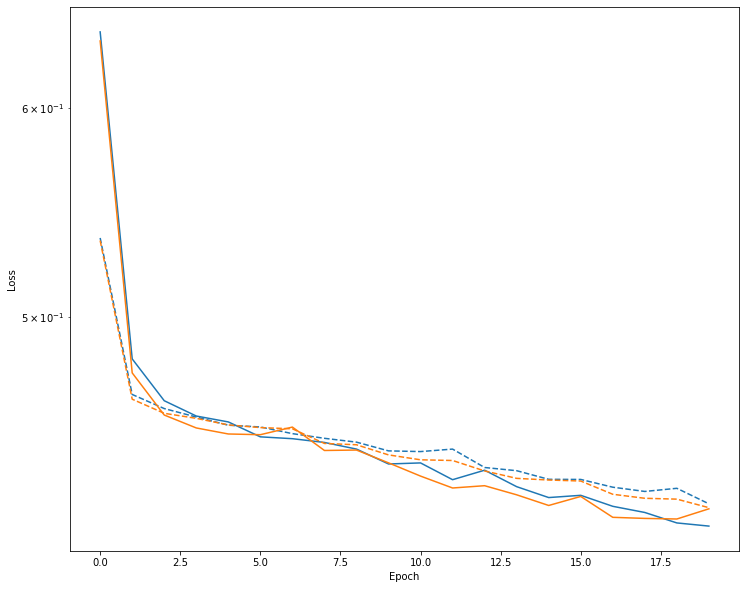

In [412]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [413]:
model = make_extranet_model()
model.load_weights(initial_weights)
baseline_history = base_model.fit(x=x_features, y=y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[early_stopping], validation_data=(val_features, y2_val.astype(None).ravel()))


Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 1600)
out_local.shape (None, 352)

Concatenated out shape: (None, 1969)
(Should be 1600 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Epoch 1/250
77/77 [==============================] - 4s 27ms/step - loss: 0.6347 - tp: 1732.0000 - fp: 337.0000 - tn: 127.0000 - fn: 558.0000 - accuracy: 0.6750 - precision: 0.8371 - recall: 0.7563 - auc: 0.5284 - prc: 0.8493 - val_loss: 0.5322 - val_tp: 254.0000 - val_fp: 52.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8301 - val_precision: 0.8301 - val_recall: 1.0000 - val_auc: 0.4705 - val_prc: 0.8107
Epoch 2/250
77/77 [==============================] - 1s 17ms/step - loss: 0.4812 - 

In [414]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

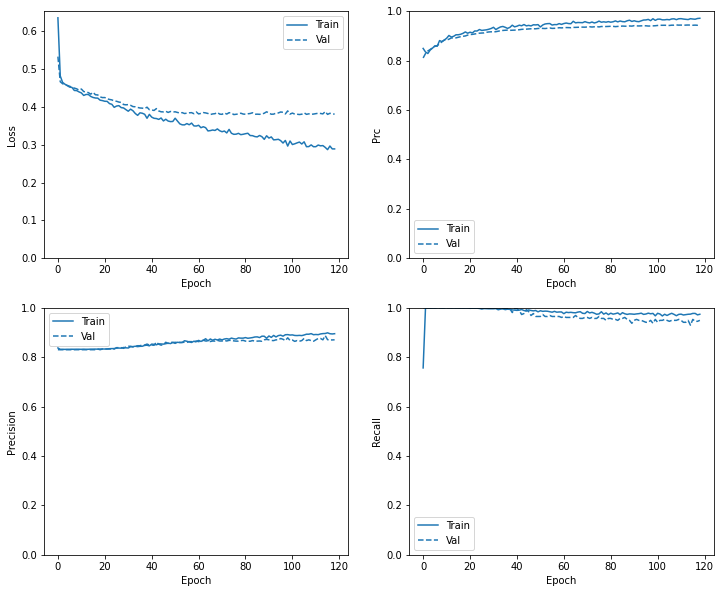

In [415]:
plot_metrics(baseline_history)

In [416]:
train_predictions_baseline = model.predict(x_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 5ms/step


In [417]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True non-exoplanets Detected (True Negatives): ', cm[0][0])
  print('True non-exoplanets Incorrectly Detected (False Positives): ', cm[0][1])
  print('Exoplanets Missed (False Negatives): ', cm[1][0])
  print('Exoplanets Detected (True Positives): ', cm[1][1])
  print('Total Exoplanets: ', np.sum(cm[1]))

loss :  0.8003377318382263
tp :  242.0
fp :  37.0
tn :  66.0
fn :  267.0
accuracy :  0.5032680034637451
precision :  0.8673835396766663
recall :  0.4754420518875122
auc :  0.6084936857223511
prc :  0.895499050617218

True non-exoplanets Detected (True Negatives):  50
True non-exoplanets Incorrectly Detected (False Positives):  1
Exoplanets Missed (False Negatives):  254
Exoplanets Detected (True Positives):  1
Total Exoplanets:  255


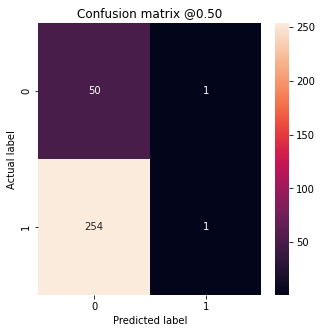

In [418]:
baseline_results = model.evaluate(test_features, y2_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y2_test, test_predictions_baseline)

In [419]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')



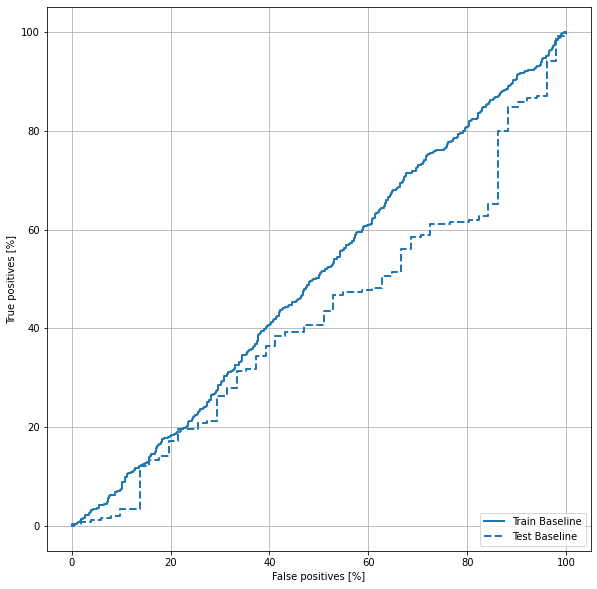

In [420]:
plot_roc("Train Baseline", y2_train.astype(None).ravel(), train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y2_test.astype(None).ravel(), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [421]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0.0,1.0])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

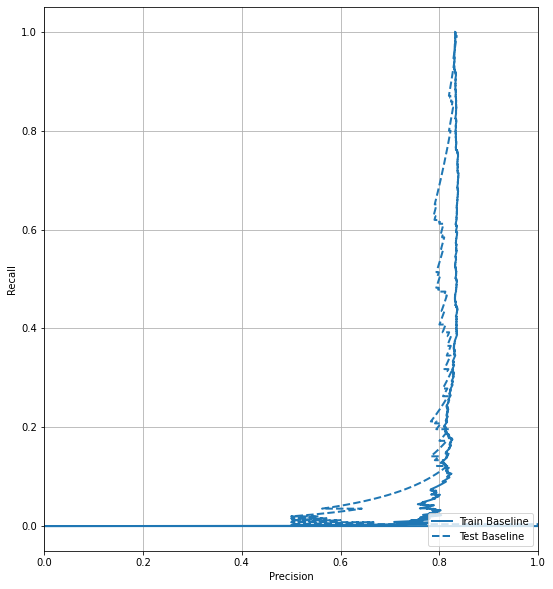

In [422]:
plot_prc("Train Baseline", y2_train.astype(None).ravel(), train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y2_test.astype(None).ravel(), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [423]:
total = pos+neg
weight_for_0 = (1/neg)*(total/2.0)
weight_for_1 = (1/pos)*(total/2.0)

class_weight = {0:2.97, 1:0.6}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.97


In [424]:
weighted_model = make_extranet_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    x_features,
    y2_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(val_features, y2_val),
    # The class weights go here
    class_weight=class_weight)

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)

Shape after flatten outputs
out_global.shape (None, 1600)
out_local.shape (None, 352)

Concatenated out shape: (None, 1969)
(Should be 1600 global + 352 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Epoch 1/250
77/77 [==============================] - 4s 26ms/step - loss: 0.6968 - tp: 767.0000 - fp: 126.0000 - tn: 389.0000 - fn: 1778.0000 - accuracy: 0.3778 - precision: 0.8589 - recall: 0.3014 - auc: 0.5350 - prc: 0.8556 - val_loss: 0.7027 - val_tp: 114.0000 - val_fp: 25.0000 - val_tn: 27.0000 - val_fn: 140.0000 - val_accuracy: 0.4608 - val_precision: 0.8201 - val_recall: 0.4488 - val_auc: 0.4679 - val_prc: 0.8200
Epoch 2/250
77/77 [==============================] - 1s 16ms/step - loss: 0.6865 - tp: 1

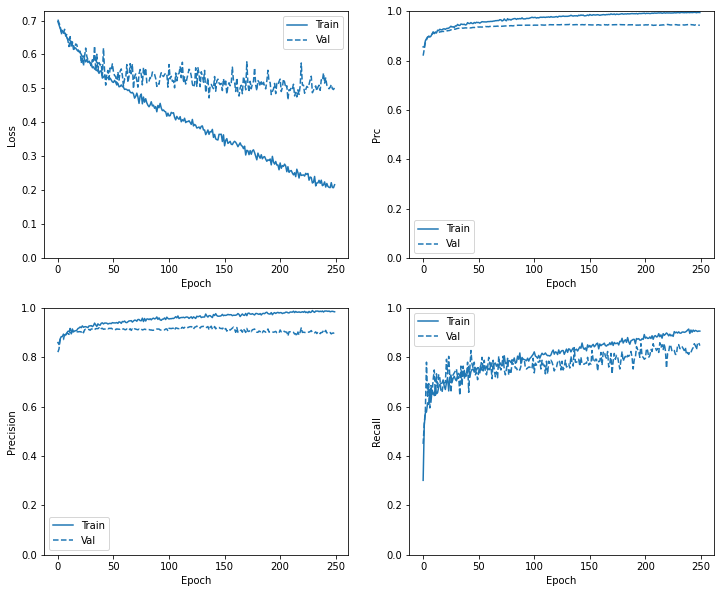

In [425]:
plot_metrics(weighted_history)

In [426]:
train_predictions_weighted = weighted_model.predict(x_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 4ms/step


loss :  0.5501165390014648
tp :  209.0
fp :  23.0
tn :  28.0
fn :  46.0
accuracy :  0.7745097875595093
precision :  0.9008620977401733
recall :  0.8196078538894653
auc :  0.7791234254837036
prc :  0.9364991784095764

True non-exoplanets Detected (True Negatives):  28
True non-exoplanets Incorrectly Detected (False Positives):  23
Exoplanets Missed (False Negatives):  46
Exoplanets Detected (True Positives):  209
Total Exoplanets:  255


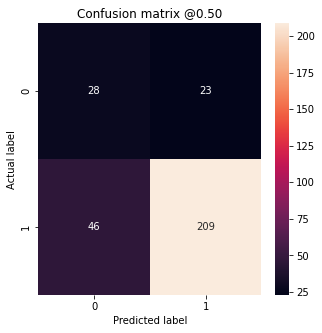

In [427]:
weighted_results = weighted_model.evaluate(test_features, y2_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y2_test, test_predictions_weighted)

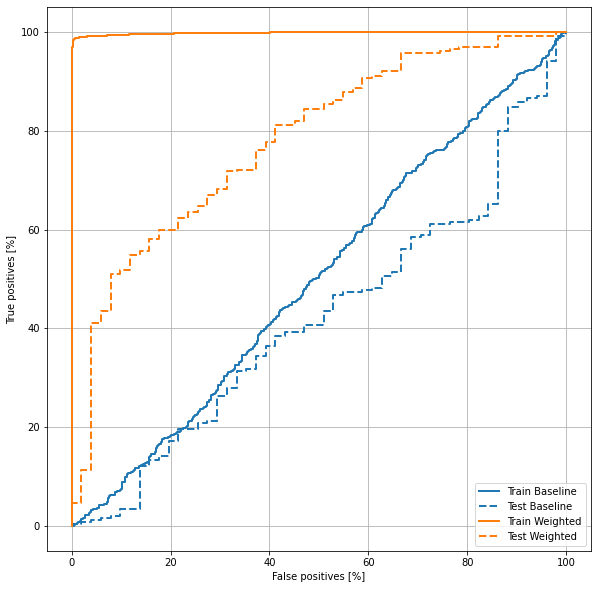

In [428]:
plot_roc("Train Baseline", y2_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y2_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y2_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y2_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

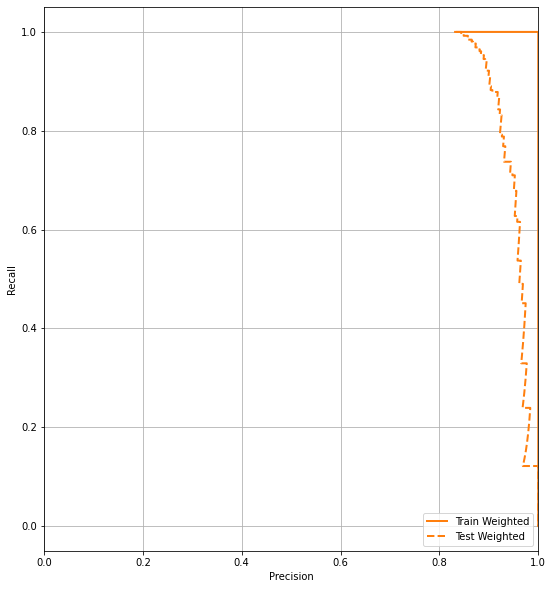

In [380]:


plot_prc("Train Weighted", y2_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y2_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [381]:
bool_train_labels = y_train != 0.0

bool_train_labels

array([False,  True,  True, ...,  True,  True,  True])

In [382]:
pos_features = [
    x_features[0][bool_train_labels], 
    x_features[1][bool_train_labels], 
    x_features[2][bool_train_labels], 
    x_features[3][bool_train_labels], 
    x_features[4][bool_train_labels]
]

neg_features = [
    x_features[0][~bool_train_labels], 
    x_features[1][~bool_train_labels], 
    x_features[2][~bool_train_labels], 
    x_features[3][~bool_train_labels], 
    x_features[4][~bool_train_labels]
]

pos_labels = y2_train[bool_train_labels]
neg_labels = y2_train[~bool_train_labels]

In [383]:
ids = np.arange(len(pos_features[0]))
choices = np.random.choice(ids, len(neg_features[0]))

res_pos_features = [
    pos_features[0][choices], 
    pos_features[1][choices], 
    pos_features[2][choices], 
    pos_features[3][choices], 
    pos_features[4][choices]
]

res_pos_labels = pos_labels[choices]


In [384]:
resampled_features = [
    np.concatenate([res_pos_features[0], neg_features[0]], axis=0), 
    np.concatenate([res_pos_features[1], neg_features[1]], axis=0), 
    np.concatenate([res_pos_features[2], neg_features[2]], axis=0), 
    np.concatenate([res_pos_features[3], neg_features[3]], axis=0), 
    np.concatenate([res_pos_features[4], neg_features[4]], axis=0)
]

resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = [
    resampled_features[0][order],
    resampled_features[1][order],
    resampled_features[2][order],
    resampled_features[3][order],
    resampled_features[4][order]
]
resampled_labels = resampled_labels[order]

In [385]:
pd.Series(resampled_labels).value_counts()

1.0    412
0.0    412
dtype: int64

In [333]:
from gc import callbacks


resampled_model = make_extranetxs_model()

resampled_history = resampled_model.fit(resampled_features, resampled_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=[val_features, y2_val])

Creating Extranet model
x_local_all.shape (None, 122)
x_global_all.shape (None, 402)

Shape after reshape
x_local_all.shape (None, 61, 2)
x_global_all.shape (None, 201, 2)

Shape after model outputs
out_global.shape (None, 50, 32)
out_local.shape (None, 11, 32)
out global shape after global pooling: (None, 32)
out local shape after global pooling: (None, 32)

Shape after flatten outputs
out_global.shape (None, 32)
out_local.shape (None, 32)

Concatenated out shape: (None, 81)
(Should be 32 global + 32 local + 17 stellar params)

Shape of output after final layer: (None, 1)
Epoch 1/250
26/26 [==============================] - 3s 45ms/step - loss: 0.6965 - tp: 410.0000 - fp: 215.0000 - tn: 248.0000 - fn: 257.0000 - accuracy: 0.5823 - precision: 0.6560 - recall: 0.6147 - auc: 0.6477 - prc: 0.7636 - val_loss: 0.6829 - val_tp: 150.0000 - val_fp: 24.0000 - val_tn: 28.0000 - val_fn: 104.0000 - val_accuracy: 0.5817 - val_precision: 0.8621 - val_recall: 0.5906 - val_auc: 0.5686 - val_prc: 0.851

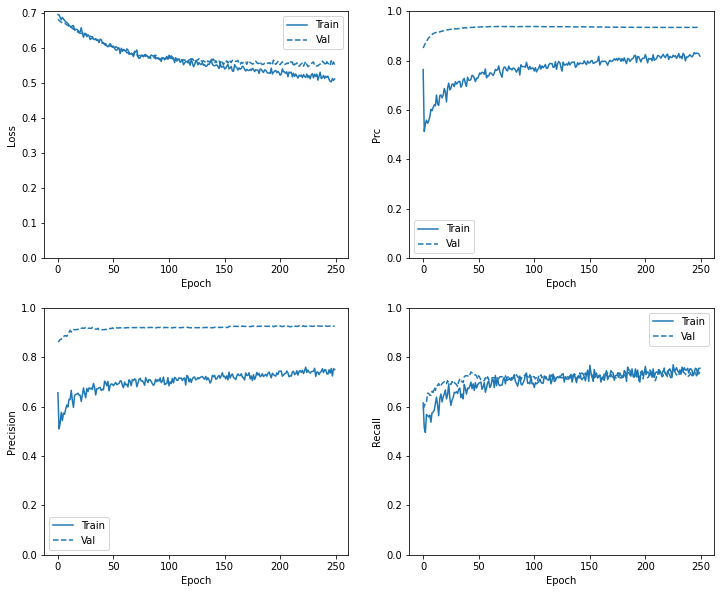

In [334]:
plot_metrics(resampled_history)

In [335]:
train_predictions_resampled = resampled_model.predict(x_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

10/10 [==============================] - 0s 3ms/step


loss :  0.5433705449104309
tp :  190.0
fp :  15.0
tn :  36.0
fn :  65.0
accuracy :  0.7385621070861816
precision :  0.9268292784690857
recall :  0.7450980544090271
auc :  0.8103806376457214
prc :  0.952308714389801

True non-exoplanets Detected (True Negatives):  36
True non-exoplanets Incorrectly Detected (False Positives):  15
Exoplanets Missed (False Negatives):  65
Exoplanets Detected (True Positives):  190
Total Exoplanets:  255


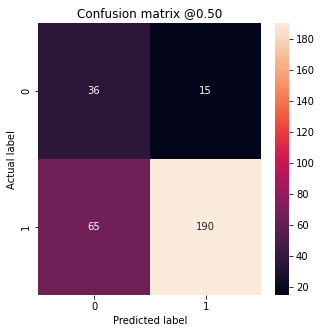

In [336]:
resampled_results = resampled_model.evaluate(test_features, y2_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y2_test, test_predictions_resampled)

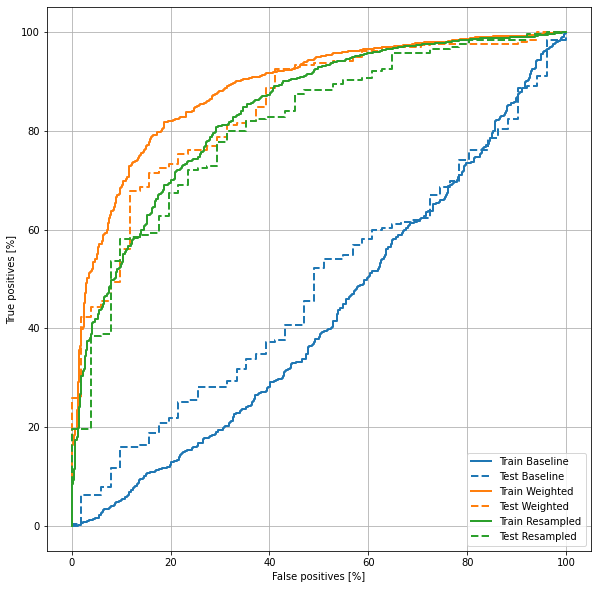

In [337]:
plot_roc("Train Baseline", y2_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y2_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y2_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y2_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y2_train, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", y2_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

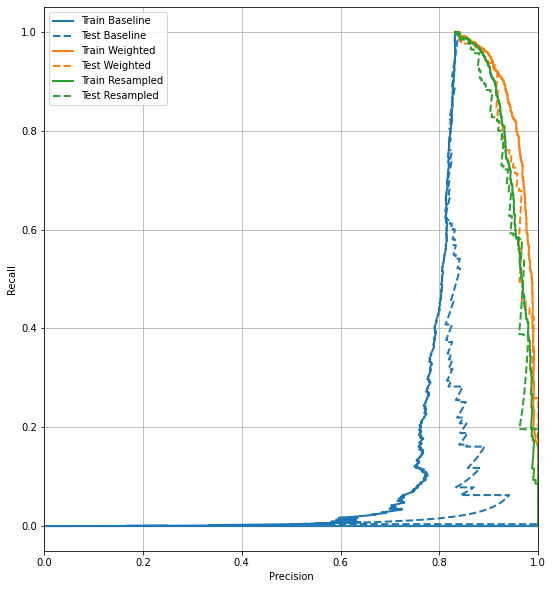

In [338]:
plot_prc("Train Baseline", y2_train, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", y2_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", y2_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y2_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", y2_train, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", y2_test, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='upper left');

In [339]:

test_output = weighted_model.predict(test_features)

test_gt = y2_test.astype(None).ravel()
test_output = test_predictions_weighted
save("./outputs/train_y_output.npy", test_output)

10/10 [==============================] - 0s 3ms/step


In [340]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay

########################################
####### CALCULATE STATISTICS ###########
########################################

### setup screen output
print("\nCALCULATING METRICS...\n")

### calculate average precision & precision-recall curves
AP = average_precision_score(test_gt, test_output, average=None)
# print("   average precision = {0:0.4f}\n".format(AP))

### calculate precision-recall curve
P, R, _ = precision_recall_curve(test_gt, test_output)

tpr, fpr, _ = roc_curve(test_gt, test_output)

### calculate confusion matrix based on different thresholds
thresh = [0.5, 0.6, 0.7, 0.8, 0.9]
prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))

for n, nval in enumerate(thresh):
    pred_byte = np.zeros(len(test_output))
    for i, val in enumerate(test_output):
        if val > nval:
            pred_byte[i] = 1.0
        else:
            pred_byte[i] = 0.0
    prec_thresh[n] = precision_score(test_gt, pred_byte, zero_division=1)
    recall_thresh[n] = recall_score(test_gt, pred_byte, zero_division=1)
    print("   thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
    tn, fp, fn, tp = confusion_matrix(test_gt, pred_byte).ravel()
    print("      TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))




CALCULATING METRICS...

   thresh = 0.50, precision = 0.93, recall = 0.81
      TN = 35, FP = 16, FN = 48, TP = 207
   thresh = 0.60, precision = 0.94, recall = 0.74
      TN = 40, FP = 11, FN = 67, TP = 188
   thresh = 0.70, precision = 0.96, recall = 0.63
      TN = 45, FP = 6, FN = 95, TP = 160
   thresh = 0.80, precision = 0.99, recall = 0.40
      TN = 50, FP = 1, FN = 153, TP = 102
   thresh = 0.90, precision = 1.00, recall = 0.16
      TN = 51, FP = 0, FN = 213, TP = 42


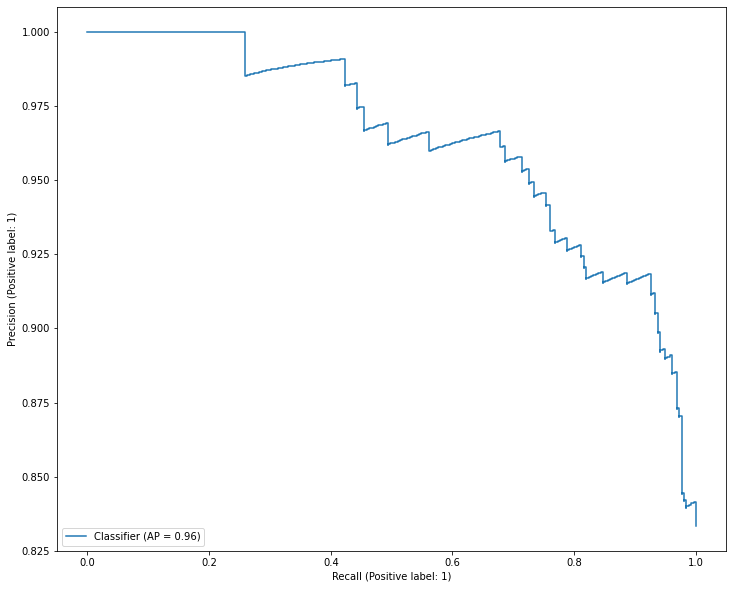

In [341]:
import matplotlib.pyplot as plt

PrecisionRecallDisplay.from_predictions(test_gt, test_output)

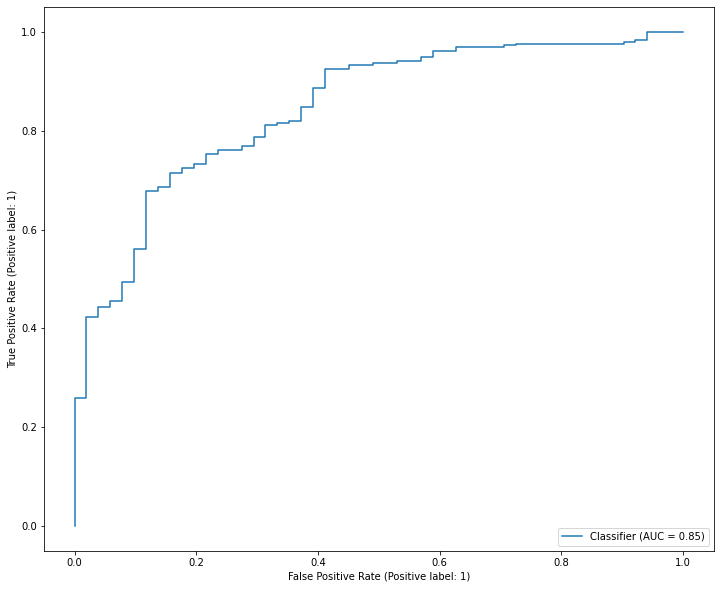

In [342]:
RocCurveDisplay.from_predictions(test_gt, test_output)

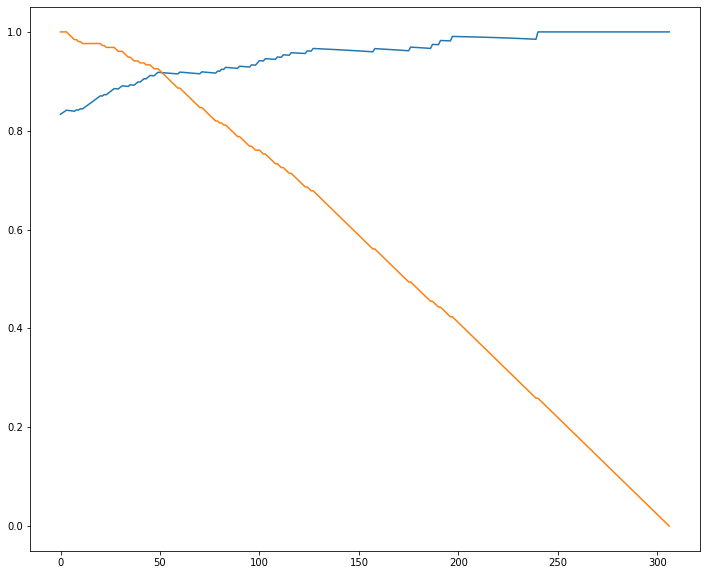

In [343]:
plt.plot(np.arange(len(P)), P)
plt.plot(np.arange(len(R)), R)

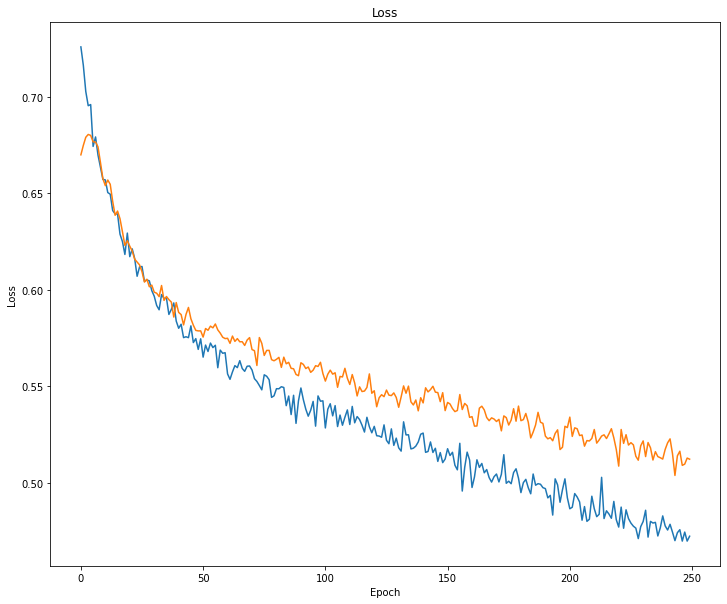

In [344]:
plt.plot(weighted_history.epoch,weighted_history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(weighted_history.epoch, weighted_history.history['val_loss'])

In [74]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [45]:
import pandas as pd

In [47]:
pd.Series(y2_train).value_counts()

0.0    669
1.0    513
dtype: int64

In [88]:
3240+653

3893

In [92]:
417+71

488

In [93]:
71/488

0.14549180327868852

In [301]:
P

array([0.83006536, 0.83278689, 0.83552632, 0.83828383, 0.83774834,
       0.84053156, 0.84333333, 0.84280936, 0.84228188, 0.84511785,
       0.84459459, 0.8440678 , 0.84353741, 0.84300341, 0.84246575,
       0.84536082, 0.84827586, 0.84775087, 0.84722222, 0.85017422,
       0.85314685, 0.85614035, 0.85915493, 0.86219081, 0.86170213,
       0.86120996, 0.86428571, 0.86379928, 0.86330935, 0.86281588,
       0.86231884, 0.86545455, 0.86861314, 0.86813187, 0.86764706,
       0.86715867, 0.87037037, 0.86988848, 0.86940299, 0.86891386,
       0.87218045, 0.8754717 , 0.87878788, 0.878327  , 0.8778626 ,
       0.87739464, 0.88076923, 0.88030888, 0.87984496, 0.88326848,
       0.8828125 , 0.88235294, 0.88582677, 0.88932806, 0.88888889,
       0.88844622, 0.888     , 0.8875502 , 0.88709677, 0.89068826,
       0.8902439 , 0.89387755, 0.89344262, 0.89300412, 0.89669421,
       0.89626556, 0.89583333, 0.89539749, 0.89495798, 0.89873418,
       0.90254237, 0.90212766, 0.9017094 , 0.90128755, 0.90086

In [302]:
R

array([1.        , 1.        , 1.        , 1.        , 0.99606299,
       0.99606299, 0.99606299, 0.99212598, 0.98818898, 0.98818898,
       0.98425197, 0.98031496, 0.97637795, 0.97244094, 0.96850394,
       0.96850394, 0.96850394, 0.96456693, 0.96062992, 0.96062992,
       0.96062992, 0.96062992, 0.96062992, 0.96062992, 0.95669291,
       0.95275591, 0.95275591, 0.9488189 , 0.94488189, 0.94094488,
       0.93700787, 0.93700787, 0.93700787, 0.93307087, 0.92913386,
       0.92519685, 0.92519685, 0.92125984, 0.91732283, 0.91338583,
       0.91338583, 0.91338583, 0.91338583, 0.90944882, 0.90551181,
       0.9015748 , 0.9015748 , 0.8976378 , 0.89370079, 0.89370079,
       0.88976378, 0.88582677, 0.88582677, 0.88582677, 0.88188976,
       0.87795276, 0.87401575, 0.87007874, 0.86614173, 0.86614173,
       0.86220472, 0.86220472, 0.85826772, 0.85433071, 0.85433071,
       0.8503937 , 0.84645669, 0.84251969, 0.83858268, 0.83858268,
       0.83858268, 0.83464567, 0.83070866, 0.82677165, 0.82283